In [1]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### 1. preprocess

In [2]:
subjs, subjs_data = [202509, 'tori', 'amisha', 'adam', 'erfan'], []
for subj in subjs:
    df_subj = pd.read_csv(glob.glob(f'../results/*{subj}*csv')[0])[:-1]
    subjs_data.append(df_subj)

df_subjs = pd.concat(subjs_data, ignore_index=True)
assert len(df_subjs) == 0 or df_subjs['subj'].nunique() == len(subjs), "#rows != #subjs * #trials"
print(df_subjs.columns.tolist())
df_subjs

['thisN', 'thisTrialN', 'thisRepN', 'blockN', 'run', 'condition', 'trial_key', 'stim_file_pos', 'stim_pos', 'noise_pos', 'marker_init', 'shape', 'shape_order', 'div_pos', 'target_pos', 'subj_C0F1_val', 'subj_C1F0_val', 'target_file', 'img1_file', 'img2_file', 'block_start_resp.keys', 'block_start_resp.rt', 'block_start_resp.duration', 'marker.response', 'marker.rt', 'slider_resp.keys', 'slider_resp.rt', 'slider_resp.duration', 'submit_resp.keys', 'submit_resp.rt', 'submit_resp.duration', 'blocks.thisRepN', 'blocks.thisTrialN', 'blocks.thisN', 'blocks.thisIndex', 'trials.thisRepN', 'trials.thisTrialN', 'trials.thisN', 'trials.thisIndex', 'thisRow.t', 'notes', 'block_start.started', 'block_start_text.started', 'block_start_resp.started', 'block_start.stopped', 'blocks.block_start_resp.keys', 'blocks.block_start_resp.rt', 'blocks.block_start_resp.duration', 'baseline.started', 'ISI1.started', 'baseline.stopped', 'stim.started', 'target_stim.started', 'target_stim.stopped', 'stim.stopped',

,thisN,thisTrialN,thisRepN,blockN,run,condition,trial_key,stim_file_pos,stim_pos,noise_pos,...,Mcoin.started,Mcoin.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122
0,0.0,0.0,0.0,1.0,1.0,baseline,10.0,1.1,-0.18,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0.0,1.0,1.0,baseline,7.0,0.7,-0.26,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2.0,0.0,1.0,1.0,baseline,37.0,3.7,0.34,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,3.0,0.0,1.0,1.0,baseline,14.0,1.5,-0.10,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,4.0,0.0,1.0,1.0,baseline,8.0,0.9,-0.22,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,35.0,35.0,0.0,6.0,2.0,flat_comp,210.0,2.1,0.02,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196,36.0,36.0,0.0,6.0,2.0,flat_comp,212.0,2.3,0.06,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1197,37.0,37.0,0.0,6.0,2.0,flat_comp,218.0,2.9,0.18,4.0,...,2112.874905,2113.875868,NaN,NaN,NaN,NaN,2112.874905,2113.875868,NaN,NaN
1198,38.0,38.0,0.0,6.0,2.0,flat_comp,238.0,3.9,0.38,0.0,...,2119.716484,2120.717329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_subjs = pd.DataFrame()
subj = '202509.0'

# init new cols
for col in ['dir_flip', 'sess_flip',
            'chosen_pos_aligned', 'div_pos_aligned', 'stim_pos_aligned',
            'class_true', 'class_pred', 'err_type',
            'right_bias', 'abs_diff_pos', 'dist_moved', 'normed_RT', 'difficulty']:
    df_subjs[col] = np.nan

for subj in subjs:
    
    df_subj = pd.read_csv(glob.glob(f'../results/*{subj}*')[0])[:240]
    
    df_subj = df_subj.sort_values(by='trial_key').reset_index(drop=True)
    assert df_subj['trial_key'].is_monotonic_increasing, 'trial_key is not sorted correctly'

    df_subj['class_true'] = np.where( df_subj['valence'] == 'rew', 1, 0 )
    assert df_subj['class_true'].sum() == len(df_subj)/2, 'class_true is imbalanced'

    # convert str to list, and store chosen position
    for col in ['positions']:
        if type(df_subj[col][0]) == str:
            df_subj.loc[:, col] = df_subj[col].apply(ast.literal_eval)
            
    df_subj['chosen_pos'] = df_subj['positions'].apply(lambda x: x[-1])
    
## must sequentially align for flips & sessions because of the double flip situations

# 1. aligning for direction flips
    df_subj['dir_flip'] = (df_subj['shape_order'] == 'flat_curv').astype(int)
    assert df_subj['dir_flip'].sum() == len(df_subj)/2
   
   # align positions to curv=left, flat=right
    for col_prefix in ['chosen_pos', 'div_pos']: # dont need to unflip stim_pos because target_pos actually gets flipped
        df_subj[col_prefix + '_aligned'] = np.where( df_subj['dir_flip'],
                                                     -df_subj[col_prefix], df_subj[col_prefix] )

# 2. aligning for session type (stim-val association)
    if df_subj['sess_type'][0] in ['A', 'C']: # adam, tori       
        df_subj['condition'] = df_subj['condition'].map({'baseline':'baseline', 'curv_comp':'pen_comp', 'flat_comp':'rew_comp'})
        df_subj['sess_flip'] = 0
        df_subj['stim_pos_aligned'] = df_subj['stim_pos']

    elif df_subj['sess_type'][0] in ['B', 'D']: # amisha, erfan     
        df_subj['condition'] = df_subj['condition'].map({'baseline':'baseline', 'curv_comp':'rew_comp', 'flat_comp':'pen_comp'})
        df_subj['sess_flip'] = 1
        df_subj['stim_pos_aligned'] = -df_subj['stim_pos']

        # align positions to penalty=left, reward=right
        for col in ['chosen_pos_aligned', 'div_pos_aligned']:
            df_subj[col] = -df_subj[col]

    df_subj['class_pred'] = (df_subj['chosen_pos_aligned'] > df_subj['div_pos_aligned']).astype(int)
    df_subj['err_type'] = df_subj['class_pred'] - df_subj['class_true']

    df_subjs = pd.concat([df_subjs, df_subj], ignore_index=True)

# accounting for older versions where large outcome was +-2
df_subjs['outcome'] = df_subjs['outcome'].replace({2: 3, -2: -3})

# calculate pred-true
df_subjs['right_bias'] = df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']
df_subjs['abs_diff_pos'] = (df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']).abs()

# RT normed by distance moved
df_subjs['dist_moved'] = (df_subjs['chosen_pos'] - df_subjs['marker_init']).abs()
df_subjs['normed_RT'] = df_subjs['trials.submit_resp.rt']/ (10 * (df_subjs['dist_moved'] + .01) )

# binary value of difficulty
df_subjs['difficulty'] = (df_subjs['target_pos'] - df_subjs['div_pos']).abs() < 0.1

df_subjs = df_subjs.copy()

# asserts

df_subjs.to_csv('../results/all_subjs_clean.csv', index=False)

print(df_subjs['outcome'].value_counts(), '\n')
print(df_subjs['correct'].value_counts(), '\n')
print(df_subjs.shape, '\n')

disp_cols = ['sess_type', 'sess_flip', 'shape_order', 'dir_flip', 'target_pos', 'shape', 'valence', 'class_true',
             'div_pos', 'div_pos_aligned', 'stim_pos', 'stim_pos_aligned', 'chosen_pos', 'chosen_pos_aligned', 'class_pred', 'err_type',
             'right_bias', 'abs_diff_pos']

df_subjs[(df_subjs['sess_type'] == 'B') &
         (df_subjs['condition'] == 'baseline') &
         (df_subjs['err_type'] != 0) &
         (df_subjs['sess_flip'] != df_subjs['dir_flip'])
        ][disp_cols][:30]


outcome
 1.0    472
 3.0    467
-1.0    116
-3.0    108
 0.0     37
Name: count, dtype: int64 

correct
1.0    939
0.0    261
Name: count, dtype: int64 

(1200, 147) 



,sess_type,sess_flip,shape_order,dir_flip,target_pos,shape,valence,class_true,div_pos,div_pos_aligned,stim_pos,stim_pos_aligned,chosen_pos,chosen_pos_aligned,class_pred,err_type,right_bias,abs_diff_pos
518,B,1.0,curv_flat,0.0,0.38,flat,pen,0.0,0.0,-0.0,0.38,-0.38,-0.052,0.052,1.0,1.0,0.432,0.432
604,B,1.0,curv_flat,0.0,-0.30,curv,rew,1.0,0.0,-0.0,-0.30,0.30,0.056,-0.056,0.0,-1.0,-0.356,0.356
606,B,1.0,curv_flat,0.0,-0.26,curv,rew,1.0,0.0,-0.0,-0.26,0.26,0.188,-0.188,0.0,-1.0,-0.448,0.448
608,B,1.0,curv_flat,0.0,-0.22,curv,rew,1.0,0.0,-0.0,-0.22,0.22,0.088,-0.088,0.0,-1.0,-0.308,0.308
610,B,1.0,curv_flat,0.0,-0.18,curv,rew,1.0,0.0,-0.0,-0.18,0.18,0.276,-0.276,0.0,-1.0,-0.456,0.456
612,B,1.0,curv_flat,0.0,-0.14,curv,rew,1.0,0.0,-0.0,-0.14,0.14,0.128,-0.128,0.0,-1.0,-0.268,0.268
614,B,1.0,curv_flat,0.0,-0.10,curv,rew,1.0,0.0,-0.0,-0.10,0.10,0.020,-0.020,0.0,-1.0,-0.120,0.120
616,B,1.0,curv_flat,0.0,-0.06,curv,rew,1.0,0.0,-0.0,-0.06,0.06,0.032,-0.032,0.0,-1.0,-0.092,0.092
620,B,1.0,curv_flat,0.0,0.02,flat,pen,0.0,0.0,-0.0,0.02,-0.02,-0.264,0.264,1.0,1.0,0.284,0.284
1096,B,1.0,curv_flat,0.0,-0.06,curv,rew,1.0,0.0,-0.0,-0.06,0.06,0.056,-0.056,0.0,-1.0,-0.116,0.116


### 2. read df

In [4]:
df_subjs = pd.read_csv('../results/all_subjs_clean.csv')
df_subjs

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,class_true,class_pred,err_type,right_bias,abs_diff_pos,...,Mcoin.started,Mcoin.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122
0,0.0,0.0,-0.352,0.0,-0.38,0.0,0.0,0.0,0.028,0.028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,-0.060,-0.0,-0.38,0.0,0.0,0.0,0.320,0.320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,-0.028,0.0,-0.34,0.0,0.0,0.0,0.312,0.312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0.0,-0.000,-0.0,-0.34,0.0,0.0,0.0,0.340,0.340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,-0.232,0.0,-0.30,0.0,0.0,0.0,0.068,0.068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1.0,1.0,-0.248,-0.2,-0.34,0.0,0.0,0.0,0.092,0.092,...,1890.456704,1891.456969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196,0.0,1.0,-0.252,-0.2,-0.38,0.0,0.0,0.0,0.128,0.128,...,1871.707362,1872.707182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1197,1.0,1.0,-0.228,-0.2,-0.38,0.0,0.0,0.0,0.152,0.152,...,2038.543722,2039.543406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1198,0.0,1.0,-0.244,-0.2,-0.38,0.0,0.0,0.0,0.136,0.136,...,2119.716484,2120.717329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
subjs = df_subjs['subj'].unique()
print(subjs)
df_analysis = df_subjs[df_subjs['subj'] == '202509.0'].copy()
df_analysis = df_subjs.copy()
df_analysis

['202509.0' 'tori' 'amisha' 'adam' 'erfan']


,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,class_true,class_pred,err_type,right_bias,abs_diff_pos,...,Mcoin.started,Mcoin.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122
0,0.0,0.0,-0.352,0.0,-0.38,0.0,0.0,0.0,0.028,0.028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,-0.060,-0.0,-0.38,0.0,0.0,0.0,0.320,0.320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,-0.028,0.0,-0.34,0.0,0.0,0.0,0.312,0.312,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,0.0,-0.000,-0.0,-0.34,0.0,0.0,0.0,0.340,0.340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,-0.232,0.0,-0.30,0.0,0.0,0.0,0.068,0.068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1.0,1.0,-0.248,-0.2,-0.34,0.0,0.0,0.0,0.092,0.092,...,1890.456704,1891.456969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196,0.0,1.0,-0.252,-0.2,-0.38,0.0,0.0,0.0,0.128,0.128,...,1871.707362,1872.707182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1197,1.0,1.0,-0.228,-0.2,-0.38,0.0,0.0,0.0,0.152,0.152,...,2038.543722,2039.543406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1198,0.0,1.0,-0.244,-0.2,-0.38,0.0,0.0,0.0,0.136,0.136,...,2119.716484,2120.717329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3. duration checks

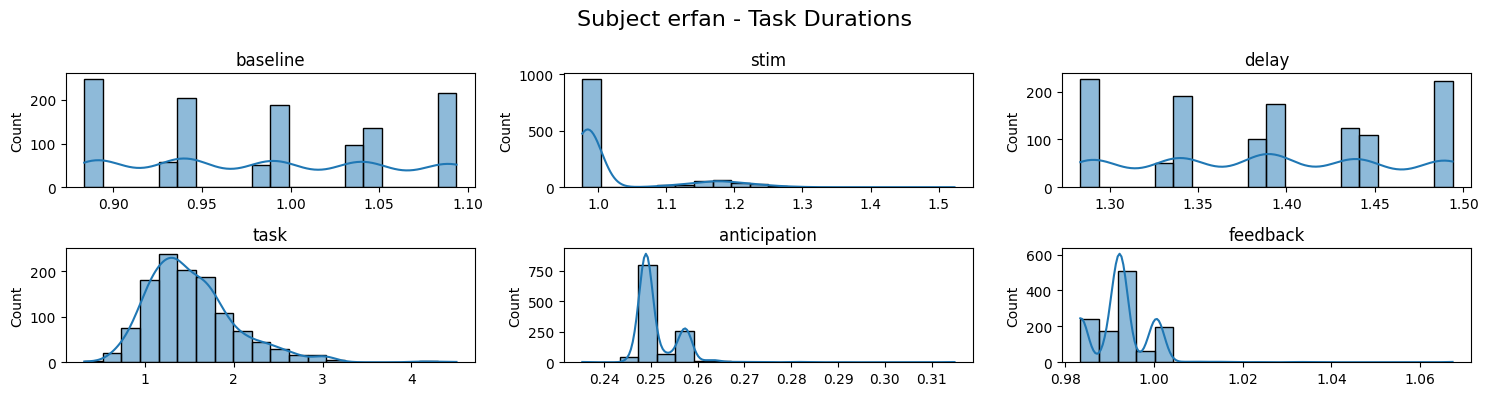

In [6]:
# create column for each phases's duration
expt_phases = ['baseline', 'stim', 'delay', 'task', 'anticipation', 'feedback']
for phase in expt_phases:
    df_analysis[f'{phase}_dur'] = df_analysis[f'{phase}.stopped'] - df_analysis[f'{phase}.started']

# sid, check if these are needed replacements
df_analysis['stim_dur'] = df_analysis['stim.stopped'] - df_analysis['target_stim.started']
df_analysis['feedback_dur'] = df_analysis['feedback.stopped'] - df_analysis['no_resp_text.started']

fig, axs = plt.subplots(2, 3, figsize=(15, 4))
axs, ax = axs.flatten(), 0

for expt_phase in expt_phases:

    sns.histplot(df_analysis[f'{expt_phase}_dur'], bins=20, kde=True, ax=axs[ax])
    axs[ax].set(title=expt_phase, xlabel='', ylabel='Count')
    ax += 1

plt.suptitle(f'Subject {subj} - Task Durations', fontsize=16)
plt.tight_layout()
plt.show()

# print which trials with feedback duration < .99
# short_feedback = df_analysis.loc[df_analysis['feedback_dur'] < 0.998]
# print(f'{len(short_feedback)} trials: {short_feedback.index.tolist()}')

## 4. positional plots

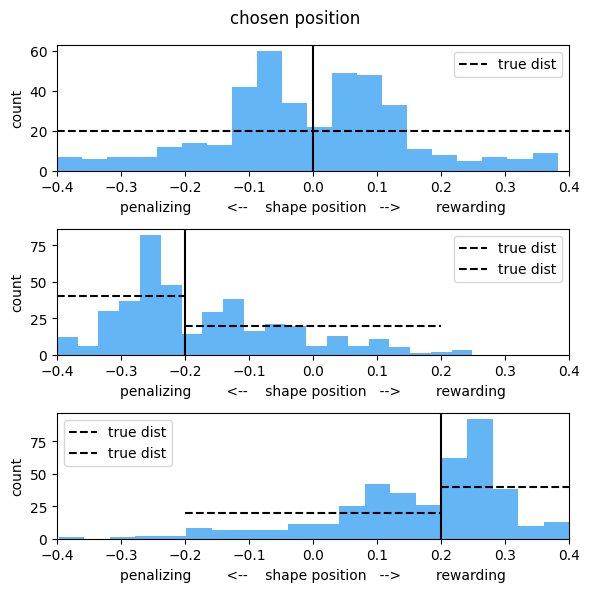

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(6, 6))
axs, ax = axs.flatten(), 0

base_count = len(df_analysis)/3/20
comp_count = len(df_analysis)/3/20*2

for cond, cond_df in df_analysis.groupby('condition'):

    axs[ax].set(xlabel='penalizing        <--    shape position   -->        rewarding', ylabel='count', xlim=(-.4, .4))
    axs[ax].hist(cond_df['chosen_pos_aligned'], bins=20, color='#64B5F6')
    if cond == 'baseline':
        axs[ax].axhline(base_count, color='black', linestyle='--', label='true dist')
    elif cond == 'pen_comp':
        axs[ax].hlines(comp_count, -.4, -.2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(base_count, -.2, .2, color='black', linestyle='--', label='true dist')
    elif cond == 'rew_comp':
        axs[ax].hlines(base_count, -.2, .2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(comp_count, .2, .4, color='black', linestyle='--', label='true dist')
    axs[ax].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')
    axs[ax].legend()
    ax += 1


plt.suptitle('chosen position')
plt.tight_layout()
plt.show()

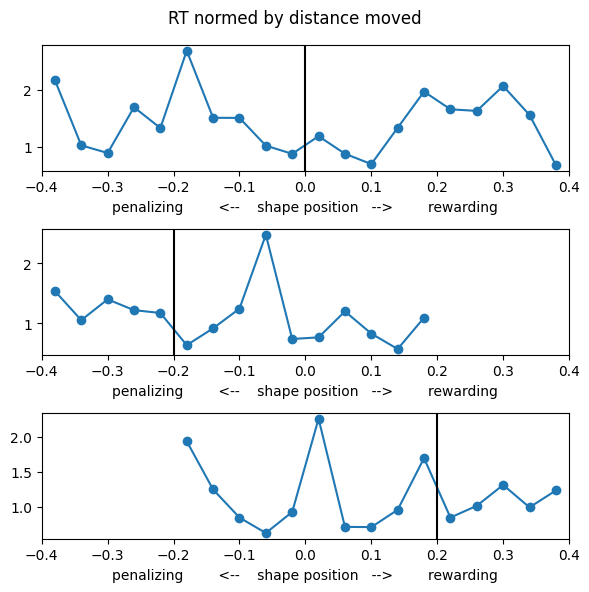

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(6, 6))
axs, ax = axs.flatten(), 0

for cond, cond_df in df_analysis.groupby('condition'):

    mean_metrics = cond_df.groupby('stim_pos_aligned')[['correct', 'normed_RT']].mean().reset_index()
    axs[ax].set(xlabel='penalizing        <--    shape position   -->        rewarding', xlim=(-.4, .4))
    # axs[ax].plot(mean_metrics['stim_pos_aligned'], mean_metrics['correct'], marker='o')    
    axs[ax].plot(mean_metrics['stim_pos_aligned'], mean_metrics['normed_RT'], marker='o')
    axs[ax].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')
    ax += 1  

# plt.suptitle('accuracy')
plt.suptitle('RT normed by distance moved')
plt.tight_layout()
plt.show()


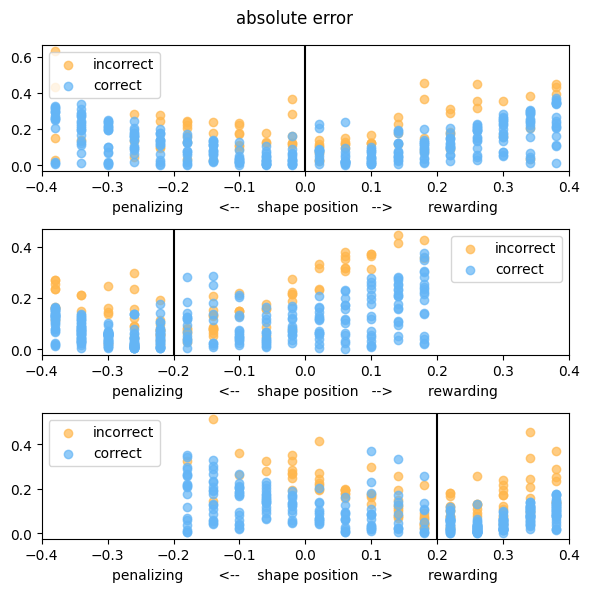

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(6, 6))
axs, ax = axs.flatten(), 0

# plot info
light_blue, light_orange ='#64B5F6', '#FFB74D'
color_map = {False: light_orange, True: light_blue}
label_map = {False: 'incorrect', True: 'correct'}

for cond, cond_df in df_analysis.groupby('condition'):

    axs[ax].set(xlabel='penalizing        <--    shape position   -->        rewarding', xlim=(-.4, .4))
    for acc, acc_df in cond_df.groupby('correct'):        
        axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['abs_diff_pos'],
                        color=color_map[acc], label=label_map[acc], alpha=0.7)
    # axs[ax].axhline(0, color='black', linestyle='--')
    axs[ax].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')
    axs[ax].legend()
    ax += 1

plt.suptitle('absolute error')
plt.tight_layout()
plt.show()


## 5. analyses by valence & compression

condition
baseline    400
pen_comp    400
rew_comp    400
Name: count, dtype: int64
correct
1.0    939
0.0    261
Name: count, dtype: int64
outcome
 1.0    472
 3.0    467
-1.0    116
-3.0    108
 0.0     37
Name: count, dtype: int64


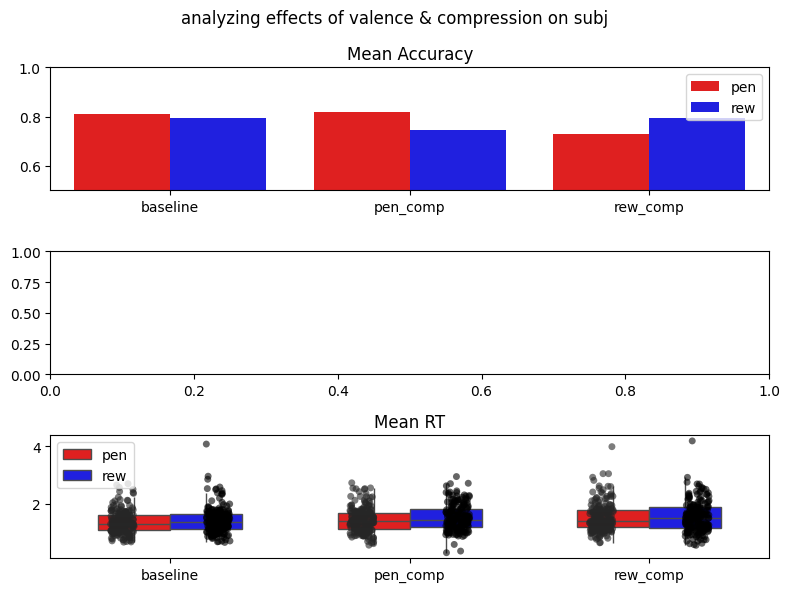

In [11]:
# df_plot = df_hard.copy()
df_plot = df_analysis.copy()

df_plot['correct'] = df_plot['correct'].apply(lambda x: 0 if x == -1 else x)
print(df_plot['condition'].value_counts())
print(df_plot['correct'].value_counts())
print(df_plot['outcome'].value_counts())

fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes = axes.flatten()
fig.suptitle('analyzing effects of valence & compression on subj')
palette, hue_order = {'rew': 'blue', 'pen': 'red'}, ['pen', 'rew']

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='condition', y='correct', hue='valence', hue_order=hue_order, palette = palette, ax=ax, errorbar=None)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')
ax.legend()

# 2.
# ax = axes[1]
# sns.boxplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order,
#             palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
# sns.stripplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order, 
#               dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title('Mean Absolute Error')
# ax.legend()

# 3.
ax = axes[2]
sns.boxplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', hue_order = hue_order,
            palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
sns.stripplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()


plt.tight_layout()
plt.show()

## analyses by valence space

percept_space
very_curvy    300
curvy         300
flat          300
very_flat     300
Name: count, dtype: int64


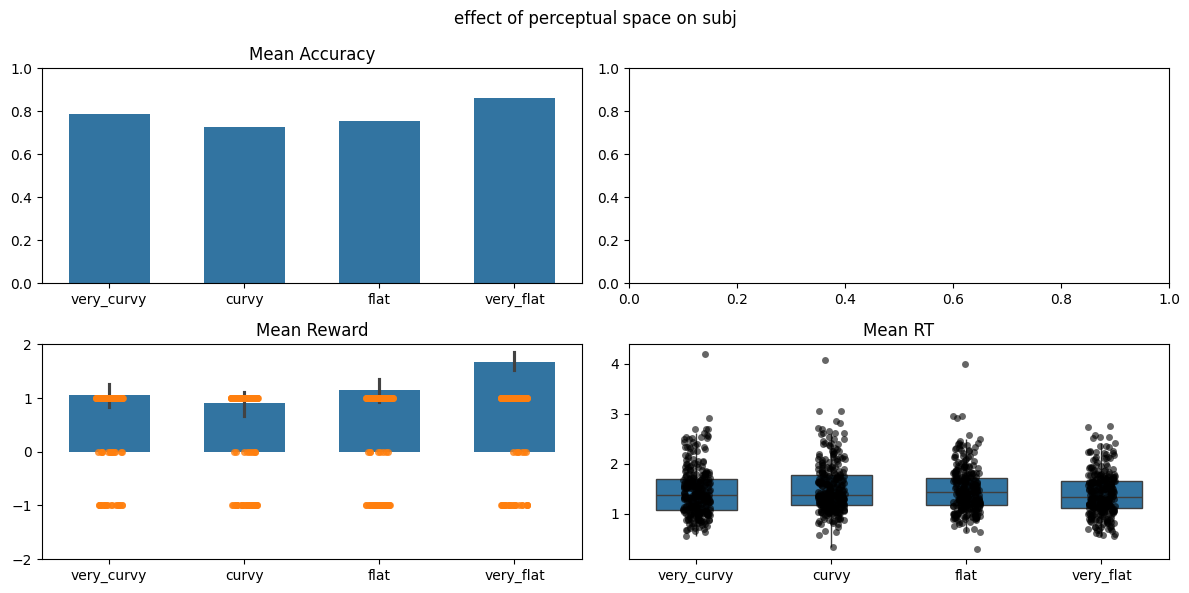

In [15]:
df_plot = df_analysis.copy()

conditions = [
    (-0.4 < df_plot['stim_pos']) & (df_plot['stim_pos'] < -0.2),
    (-0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0),
    (0 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.2),
    (0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.4)
]
percept_labels = ['very_curvy', 'curvy', 'flat', 'very_flat']
df_plot['percept_space'] = np.select(conditions, percept_labels, default= 'undefined')

# arnav's percept space will be flipped
print(df_plot['percept_space'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('effect of perceptual space on subj')

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='percept_space', y='correct', width=0.6, ax=ax, errorbar=None, order=percept_labels)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_title('Mean Accuracy')

# 2. MAE
# ax = axes[1]
# sns.boxplot(data=df_plot, x='percept_space', y='MAE_normed', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
# sns.stripplot(data=df_plot, x='percept_space', y='MAE_normed', color='black', dodge=True, alpha=0.6, jitter=True, legend=False, order=percept_labels, ax=ax)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_ylim(0, .6)
# ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
# ax.set_title('Mean Absolute Error (questionable norming)')

# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='percept_space', y='outcome', width=0.6, hue_order=hue_order, order=percept_labels, ax=ax)
sns.stripplot(data=df_plot, x='percept_space', y='outcome', dodge=True, alpha=0.8, jitter=True, order=percept_labels, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')

# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
sns.stripplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', color='black', dodge=True, alpha=0.6, jitter=True, order=percept_labels, legend=True, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')

plt.tight_layout()
plt.show()



## plot class - class_hat

In [ ]:
# Step 1: Get mean accuracy per subject (across all conditions and valences)
subj_acc = df_subjs.groupby('subj')['correct'].mean().reset_index()

# Step 2: Compute SD across those subject-level accuracies
overall_sd = subj_acc['correct'].std()

print(f"SD across subjects: {overall_sd}")


SD across subjects: 0.04652881425047876


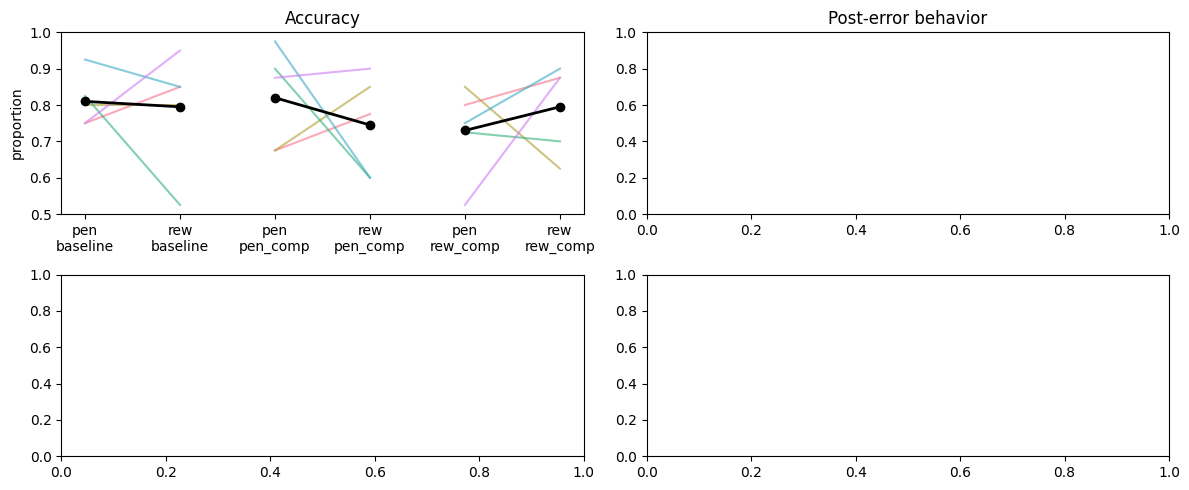

In [ ]:
# compute subject-level accuracy by valence & condition
subj_acc_df = df_subjs.groupby(['subj','condition','valence'])['correct'].mean().reset_index()

subj_acc_df['x_label'] = subj_acc_df['valence'].astype(str) + '\n' + subj_acc_df['condition'].astype(str)

# assign colors to subjects
subj_palette = dict(zip(subj_acc_df['subj'].unique(),
                        sns.color_palette('husl', n_colors=subj_acc_df['subj'].nunique())))

# compute population mean by condition & valence
pop_acc_df = subj_acc_df.groupby(['condition','valence'])['correct'].mean().reset_index()
pop_acc_df['x_label'] = pop_acc_df['valence'].astype(str) + '\n' + pop_acc_df['condition'].astype(str)

fig, axs = plt.subplots(2, 2, figsize=(12, 5))
axs, ax = axs.flatten(), 0

axs[ax].set_title('Accuracy')
# plot subjs
for subj, sub_df in subj_acc_df.groupby('subj'):
    for cond, cond_df in sub_df.groupby('condition'):
        axs[ax].plot(cond_df['x_label'], cond_df['correct'].values,
                     color=subj_palette[subj], alpha=0.6)

# plot population
for cond, cond_df in pop_acc_df.groupby('condition'):
    axs[ax].plot(cond_df['x_label'], cond_df['correct'].values,
                 color='black', marker='o', linewidth=2)

axs[ax].set(ylabel='proportion', ylim=(.5, 1))
ax += 1

# post error behavior
axs[ax].set_title('Post-error behavior')
df_post_err = df_subjs[df_subjs['correct'].shift(-1) == False]

plt.tight_layout()
plt.show()
